# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [46]:
data = pd.read_csv('train.csv')

In [47]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

train часть

In [50]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [51]:
train.fillna('', inplace=True)
train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

test часть

In [71]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [72]:
test.fillna('', inplace=True)
test.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


<Axes: >

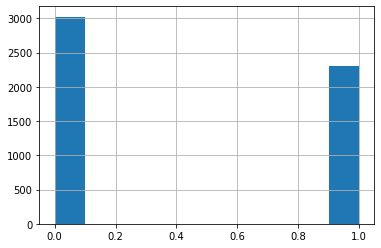

In [52]:
train.target.hist()

Обучающая выборка в целом сбалансированна

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [53]:
train.keyword.value_counts()

                         44
damage                   36
siren                    35
wreckage                 34
fatalities               33
                         ..
rescue                   16
epicentre                10
radiation%20emergency     7
inundation                7
threat                    6
Name: keyword, Length: 222, dtype: int64

Самый популярный это пропуск, следовательно берем с 1 по 11

In [55]:
popular_keywords = train.keyword.value_counts()[1:11].index.tolist()
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'refugees',
 'derail',
 'fear',
 'tsunami',
 'fatality']

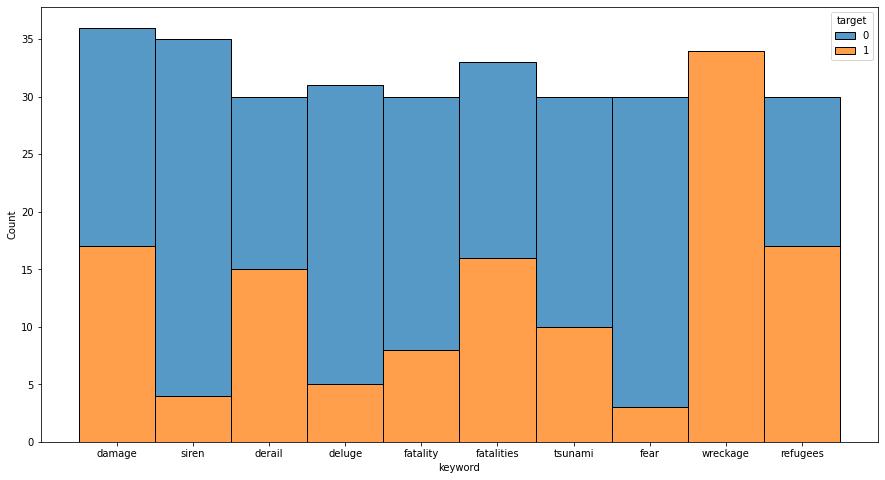

In [56]:
count_data = train[train['keyword'].isin(popular_keywords)]
plt.figure(figsize=(15, 8))
sns.histplot(data=count_data, x="keyword", hue="target", multiple="stack")
plt.show()

**Выводы**: Из полученной диаграммы видим, что наличие слова wreckage явно напрашивается как признак для положительного таргета. Также относятся к положительному классу с нормальной такой вероятностью текста, имеющие ключевые слова: damage, derail, fatalities, refugees

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

train часть

In [68]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [69]:
train_new = pd.concat([pd.DataFrame(train.keyword +' ' +train.location + ' ' + train.text, columns=['text']),
                       train.target], axis=1)

In [70]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


test часть

In [73]:
test_new = pd.concat([pd.DataFrame(test.keyword +' ' +test.location + ' ' + test.text, columns=['text']),
                       test.target], axis=1)

In [74]:
test_new.sample(5)

,text,target
3824,"first%20responders Los Angeles, CA There's sti...",0
3038,earthquake Earth 1.9 earthquake occurred 15km ...,1
4291,hellfire Beware of your temper and a loose to...,0
157,"airplane%20accident Lehigh Valley, PA Strict l...",1
2415,"derailed Washington, DC Metro acting chief Jac...",1


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [76]:
from sklearn.feature_extraction.text import CountVectorizer

In [80]:
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train.text.tolist())

In [81]:
X_train.shape

(5329, 16937)

Признаков получилось дофигища

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [82]:
vectorizer.vocabulary_

{'ashes': 1738,
 '2015': 275,
 'australia': 1857,
 'ûªs': 16908,
 'collapse': 3535,
 'at': 1783,
 'trent': 15114,
 'bridge': 2660,
 'among': 1463,
 'worst': 16331,
 'in': 7616,
 'history': 7119,
 'england': 5227,
 'bundled': 2781,
 'out': 10954,
 'for': 5963,
 '60': 666,
 'http': 7294,
 'co': 3489,
 't5trhjuau0': 14406,
 'great': 6612,
 'michigan': 9680,
 'technique': 14552,
 'camp': 2946,
 'b1g': 1937,
 'thanks': 14662,
 'to': 14912,
 'bmurph1019': 2486,
 'hail_youtsey': 6806,
 'termn8r13': 14605,
 'goblue': 6502,
 'wrestleon': 16366,
 'oaskgki6qj': 10636,
 'cnn': 3482,
 'tennessee': 14591,
 'movie': 9993,
 'theater': 14674,
 'shooting': 13398,
 'suspect': 14314,
 'killed': 8470,
 'by': 2841,
 'police': 11528,
 'di8elzswnr': 4456,
 'still': 14061,
 'rioting': 12620,
 'couple': 3806,
 'of': 10692,
 'hours': 7255,
 'left': 8827,
 'until': 15491,
 'have': 6912,
 'be': 2145,
 'up': 15501,
 'class': 3408,
 'crack': 3841,
 'the': 14671,
 'path': 11169,
 'where': 16122,
 'wiped': 16212,
 'th

In [92]:
import string
punct_list = string.punctuation#.replace('#', '').replace('@', '')
punct_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(map(str.isdigit, s))  

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(map(lambda x: x in punct_list, s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', sum(map(contains_digit, vocabulary.keys())))
    print('With punctuation:', sum(map(contains_punctuation, vocabulary.keys())))
    print('Hashtags:        ', sum(map(is_hashtag, vocabulary.keys())))
    print('Mentions:        ', sum(map(is_mention, vocabulary.keys())))


In [94]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [95]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3663
With punctuation: 300
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [97]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [99]:
# help(TweetTokenizer)

In [109]:
tweet_tokenizer = TweetTokenizer()
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)
X_train = vectorizer.fit_transform(train.text.tolist())
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3781
With punctuation: 7136
Hashtags:         1440
Mentions:         1669


Из документации: Setting strip_handles to True, the tokenizer will remove Twitter handles (e.g. usernames). Setting reduce_len to True, repeated character sequences of length 3 or greater will be replaced with sequences of length 3.

Поэтому установим эти параметры True, так как нам не важны usernames и повторяющиеся много раз символы

In [110]:
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)
X_train = vectorizer.fit_transform(train.text.tolist())
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3489
With punctuation: 5476
Hashtags:         1440
Mentions:         9


**Сравнение:** В первую очередь заметим, что токенайзер по другому разделял # => у нас остались хэштеги, что очень хорошо, так как в них содержится тема твита. Слов с пунктуацией тоже стало больше, ведь мы знаем, что это достаточно распространенный метод цензуры текста в соц сетях, от таких слов тоже не стоит отказываться

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [112]:
from string import ascii_letters
ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [116]:
import nltk
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer(language='english')

In [129]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(map(lambda c: c in ascii_letters, s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    punct_flag = all(map(lambda c: c in punct_list, s))
    bracket_flag = any([s.find(c) != -1 for c in ['(', ')', '[', ']', '{', '}']])
    return punct_flag and bracket_flag

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    tokens = tokenizer.tokenize(s.lower())
    tokens = list(filter(lambda x: contains_only_latin_letters(x) or is_emoji(x) or is_hashtag(x), tokens))
    tokens = list(filter(lambda x: x not in nltk.corpus.stopwords.words('english'), tokens))
    return list(map(snowball.stem, tokens))
    
  

In [130]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [134]:
for i in range(10):
    text = train.text.tolist()[i]
    print('='*30 + str(i+1)+ '='*30)
    print(f'Initial text: {text}')
    print(f'Tokenized text: {custom_tokenizer(text)}')

==============================1==============================
Initial text: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
Tokenized text: ['ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
==============================2==============================
Initial text: GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
Tokenized text: ['great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
==============================3==============================
Initial text: CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
Tokenized text: ['cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
==============================4==============================
Initial text: Still rioting in a couple of hour

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [162]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(train.text.tolist())
y_train = train.target.tolist()

X_test = vectorizer.transform(test.text.tolist())
y_test = test.target.tolist()

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [163]:
X_train.shape

(5329, 9258)

In [141]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       0
With punctuation: 1309
Hashtags:         1297
Mentions:         0


2. Обучите LogisticRegression на полученных признаках.


In [142]:
from sklearn.linear_model import LogisticRegression

In [143]:
logreg = LogisticRegression().fit(X_train, y_train)

3. Посчитайте метрику f1-score на тестовых данных.

In [144]:
from sklearn.metrics import f1_score
print(f'F1 score: {f1_score(y_test, logreg.predict(X_test))}')

F1 score: 0.7513691128148959


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(train.text.tolist())
y_train = train.target.tolist()

X_test = vectorizer.transform(test.text.tolist())
y_test = test.target.tolist()

logreg = LogisticRegression().fit(X_train, y_train)

print(f'F1 score: {f1_score(y_test, logreg.predict(X_test))}')

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7444507683551508


In [146]:
X_train.shape

(5329, 9258)

1. **Ответ:** ну качество чуть чуть упало

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [153]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
X_train = vectorizer.fit_transform(train.text.tolist())
y_train = train.target.tolist()

X_test = vectorizer.transform(test.text.tolist())
y_test = test.target.tolist()

logreg = LogisticRegression().fit(X_train, y_train)

print(f'F1 score: {f1_score(y_test, logreg.predict(X_test))}')

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7444507683551508


In [154]:
X_train.shape

(5329, 9258)

2. **Ответ:** Размер матрицы никак не уменьшился => качество модели такое же. 0.9 все еще многовато, похоже у всех слов пропорция документов меньше этого числа

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [159]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.005)
X_train = vectorizer.fit_transform(train.text.tolist())
y_train = train.target.tolist()

X_test = vectorizer.transform(test.text.tolist())
y_test = test.target.tolist()

logreg = LogisticRegression().fit(X_train, y_train)

print(f'F1 score: {f1_score(y_test, logreg.predict(X_test))}')
X_train.shape

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7025813692480359


(5329, 322)

3. **Ответ:** словарь ооочень сильно уменьшился, учитывая, что min_df=0.005 (до этого я пробовал 0.1, 0.01 и слов не оставалось), значит, что все слова достаточно редки. Плюсом из-за такого сильно сокращения словаря итоговый скор упал, однако, всего на 5 процентов. Это говорит нам о том, что мы потеряли не слишком много важных слов. Наверное, оптимальным размером словаря будет 1к

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [160]:
from sklearn.feature_extraction.text import HashingVectorizer

In [161]:
vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
X_train = vectorizer.fit_transform(train.text.tolist())
y_train = train.target.tolist()

X_test = vectorizer.transform(test.text.tolist())
y_test = test.target.tolist()

logreg = LogisticRegression().fit(X_train, y_train)

print(f'F1 score: {f1_score(y_test, logreg.predict(X_test))}')

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7233065442020665


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Ну судя по метрике, лучше всего оказался подход с CountVectorizer'ом, однако, тут мы проигрываем по памяти, так как слишком много фичей. Чуть хуже справился tf-idf, в нем мы можем подрезать словарь по важности слов и не сильно проиграть в качестве, зато экономим память. Между ними вписался HashingVectorizer, который тоже неплохо отработал с кол-ом фичей в 5к

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

**Ответ**: ну в задании 8 я уже добился этого...вроде я автоматом получаю балл здесь)) Но вообще, если бы я хотел еще попытаться повысить скор, я бы начал эксперементировать с токенайзером и параметрами векторайзеров в кросс-валидации